In [1]:
%env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

env: PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd 
import os

In [3]:
device = torch.device('mps')

In [4]:
TRAIN_ROOT = "data/brain_mri/training"
TEST_ROOT = "data/brain_mri/testing"

In [5]:
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((254,254)),
                      transforms.ToTensor()
        ])
)

In [6]:
test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

In [7]:
device

device(type='mps')

In [8]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT) #This pretrained model is used as a feature extractor in the CNNModel class

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features 
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
        x = self.vgg16(x)
        return x


In [10]:
nmodel = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
nmodel

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
for param in nmodel.parameters():
    param.requires_grad = False

In [12]:
num_classes = 4 # assuming 2 classes: tumor and non-tumor
in_features = nmodel.classifier[-1].in_features 
nmodel.classifier[-1] = nn.Linear(in_features, num_classes)

In [13]:
nmodel

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
nmodel = nmodel.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nmodel.classifier.parameters(), lr=0.001)

In [16]:
num_epochs = 5
for epoch in range(num_epochs):
    # Train for one epoch
    running_loss = 0.0
    nmodel.train()
    for inputs, labels in train_loader:
        # Forward pass
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = nmodel(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        print("the running losss is ---->", loss)
    epoch_loss = running_loss / len(train_loader.dataset)
    print("epoch loss---->",epoch_loss)

the running losss is ----> tensor(1.5783, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.3386, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.5144, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.5256, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.3182, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.3683, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.0670, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.0352, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.5313, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.1885, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.0362, device='mps:0', grad_fn=<NllLossBackward0>)
the running losss is ----> tensor(1.0745, device='mps:

In [17]:
torch.save(nmodel.state_dict(), 'model_weights.pth')

In [19]:
new_model = CNNModel()
new_model.vgg16.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

In [21]:
new_model = new_model.to(device)

In [37]:
import pandas as pd
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = new_model(inputs).max(1).indices.detach().cpu().numpy()
comparison = pd.DataFrame()
print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
comparison["labels"] = labels

comparison["outputs"] = outputs
comparison

Batch accuracy:  0.5


,labels,outputs
0,0,3
1,0,3
2,0,2
3,3,3
4,0,1
5,0,2
6,1,2
7,0,0
8,1,1
9,0,0


In [62]:
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']): 
        if isinstance(layer, nn.Linear): 
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations
    
    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0 
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)
            
            # Apply variants of LRP depending on the depth
            # see: https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9
            
            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data                                     
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward(); 
            c = activations[layer].grad       
            # Assign new relevance values           
            relevances[layer] = (activations[layer]*c).data                          
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]

length of image id --->  32
length of lable --->  32
3
3
Groundtruth for this image:  pituitary_tumor


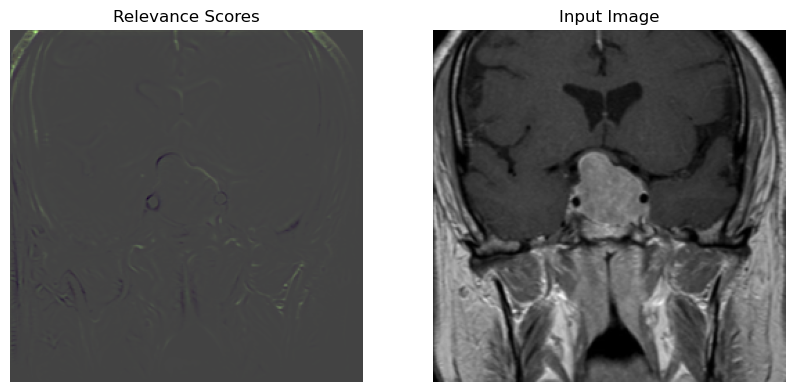

In [63]:
image_id = 3
image_relevances = apply_lrp_on_vgg16(new_model, inputs[image_id].to(device))
image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()
image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                image_relevances.max()), 
                                                (0, 1))[0]
# Show relevances
pred_label = list(test_dataset.class_to_idx.keys())[           #pred_label is a variable that stores the predicted label for a given image based on the class index of the test dataset
             list(test_dataset.class_to_idx.values())
            .index(labels[image_id])]
print("length of image id ---> ",len(outputs))
print("length of lable ---> ",len(labels))
#outputs and labels are lists that store the model's predicted output and ground truth label for each image in the test dataset.
print(outputs[image_id])
print(labels[image_id])
if outputs[image_id] == labels[image_id]:         #image_id is an index that represents the current image being evaluated
    print("Groundtruth for this image: ", pred_label)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].axis('off')
    axs[0].imshow(image_relevances[:, :, :], cmap="seismic")
    axs[0].set_title('Relevance Scores')
    axs[1].axis('off')
    axs[1].imshow(inputs[image_id].permute(1, 2, 0).detach().cpu().numpy())
    axs[1].set_title('Input Image')

    plt.show()
else:
    print("This image is not classified correctly.")

In [19]:
pre = list(test_dataset.class_to_idx.values())
pre

[0, 1, 2, 3]